# TBCK
TBCK is a conserved protein kinase that associates with the mitotic apparatus and regulates cell size, cell proliferation, and MTOR (601231) signaling.
[Infantile hypotonia with psychomotor retardation and characteristic facies-3 (IHPRF3) ](https://omim.org/entry/616900) is caused by homozygous or compound heterozygous mutation in the TBCK gene.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


### TBCK
We use the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for TBCK.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'TBCK'
mane_tx_id = 'NM_001163435.3'
mane_protein_id = 'NP_001156907.2' # TBC domain-containing protein kinase-like protein isoform a
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 41/41 [00:05<00:00,  7.68 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
35,Hypotonia
34,Motor delay
32,Global developmental delay
26,Seizure
20,Hyporeflexia
18,Absent speech
17,Coarse facial features
14,Macroglossia
14,"Intellectual disability, profound"
14,Narrow forehead


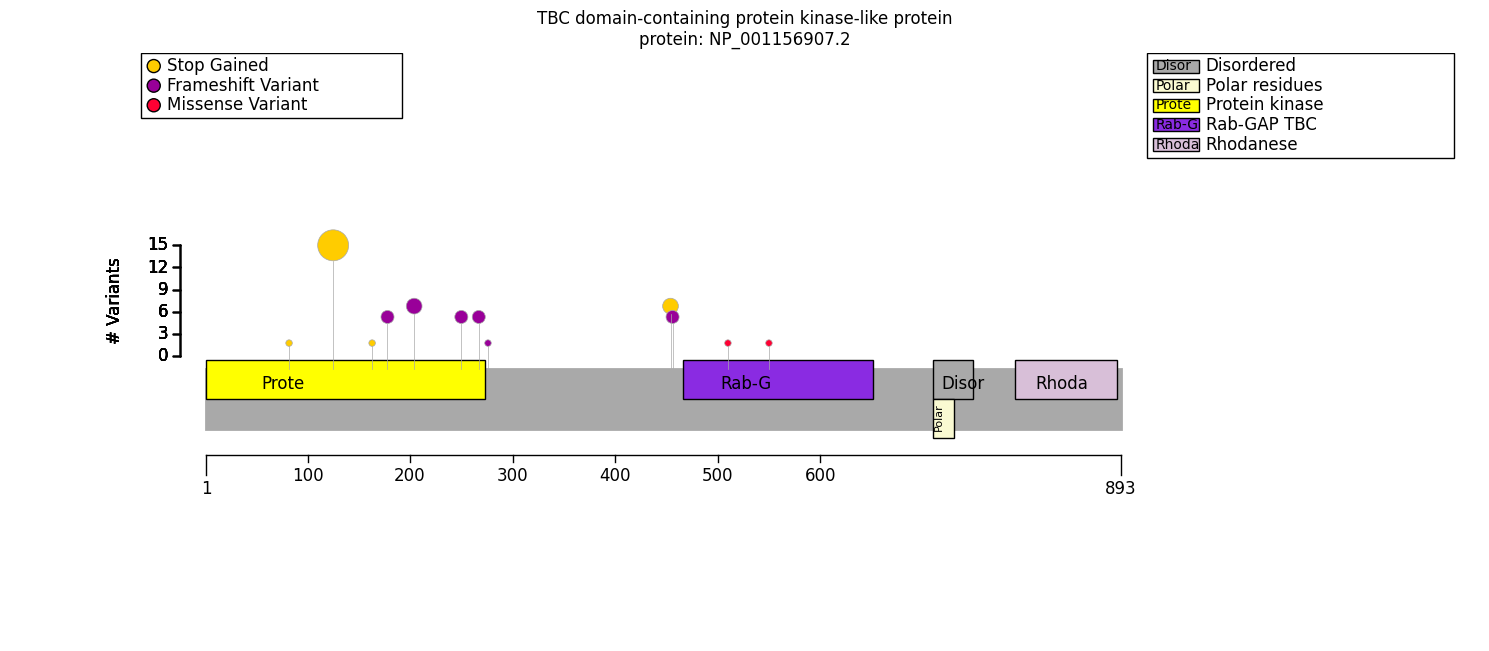

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

tbck_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
tbck_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
26,Protein kinase,Domain,2 - 273,p.Gln164Ter; p.Gln205ProfsTer8; p.Arg126Ter; p.Met268ArgfsTer26; p.Arg83Ter; p.Lys252Ter; p.Leu179ArgfsTer11
2,Rab-GAP TBC,Domain,467 - 651,p.Arg511His; p.Leu551Pro
0,Disordered,Region,711 - 749,
0,Polar residues,Compositional bias,711 - 730,
0,Rhodanese,Domain,791 - 889,


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf = biallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    partitions=((0,1), (2,)),
    a_label="missense", 
    b_label="other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,37
HMF02,Skipping term because no genotype has more than one observed HPO count,1
HMF03,Skipping term because of a child term with the same individual counts,7
HMF05,Skipping term because one genotype had zero observations,2
HMF08,Skipping general term,72
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,192


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense/missense OR missense/other,other/other,Corrected p values,p values
Seizure [HP:0001250],0/2 (0%),28/37 (76%),1.0,0.074224
Scoliosis [HP:0002650],1/1 (100%),3/16 (19%),1.0,0.235294
Absent speech [HP:0001344],0/1 (0%),18/23 (78%),1.0,0.250000
Hyporeflexia [HP:0001265],1/2 (50%),19/23 (83%),1.0,0.366667
Deeply set eye [HP:0000490],1/2 (50%),5/19 (26%),1.0,0.500000
Macroglossia [HP:0000158],0/2 (0%),14/32 (44%),1.0,0.500891
Global brain atrophy [HP:0002283],0/1 (0%),8/20 (40%),1.0,1.000000
Abnormal facial shape [HP:0001999],1/1 (100%),16/16 (100%),1.0,1.000000
Abnormal forehead morphology [HP:0000290],1/1 (100%),19/19 (100%),1.0,1.000000
Delayed speech and language development [HP:0000750],1/1 (100%),24/24 (100%),1.0,1.000000


In [10]:
from gpsea.analysis.predicate import variant_key

r126ter = variant_key("4_106262103_106262103_G_A") #c.376C>T; p.Arg126Ter
r126ter_clf = biallelic_classifier(a_predicate=r126ter, 
                          b_predicate=~r126ter,
                          partitions=((0,), (1,2)),
                          a_label="R126*", 
                          b_label="other")
r126ter_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=r126ter_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=r126ter_result)

Allele group,R126*/R126*,R126*/other OR other/other,Corrected p values,p values
Macroglossia [HP:0000158],11/12 (92%),3/22 (14%),0.000336,0.000013
Developmental regression [HP:0002376],9/12 (75%),2/22 (9%),0.002284,0.000183
Seizure [HP:0001250],12/12 (100%),16/27 (59%),0.065229,0.008690
Coarse facial features [HP:0000280],10/12 (83%),7/22 (32%),0.065229,0.010437
Scoliosis [HP:0002650],2/2 (100%),2/15 (13%),0.220588,0.044118
Global brain atrophy [HP:0002283],5/7 (71%),3/14 (21%),0.231338,0.055521
Hirsutism [HP:0001007],1/2 (50%),3/20 (15%),1.000000,0.337662
Hyporeflexia [HP:0001265],4/4 (100%),16/21 (76%),1.000000,0.549407
Macrocephaly [HP:0000256],1/2 (50%),5/15 (33%),1.000000,1.000000
Abnormal forehead morphology [HP:0000290],10/10 (100%),10/10 (100%),1.000000,1.000000


In [11]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo, mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Macroglossia [HP:0000158],1/12 (8%),13/22 (59%),0.120022,0.009040
Coarse facial features [HP:0000280],2/12 (17%),15/22 (68%),0.120022,0.010437
Global brain atrophy [HP:0002283],1/9 (11%),7/12 (58%),0.512693,0.066873
Hyporeflexia [HP:0001265],11/12 (92%),9/13 (69%),1.000000,0.321739
Tented upper lip vermilion [HP:0010804],2/10 (20%),5/11 (45%),1.000000,0.361455
Motor delay [HP:0001270],13/14 (93%),21/21 (100%),1.000000,0.400000
Absent speech [HP:0001344],11/14 (79%),7/10 (70%),1.000000,0.665332
Abnormal axial skeleton morphology [HP:0009121],10/10 (100%),9/9 (100%),1.000000,1.000000
Reduced tendon reflexes [HP:0001315],11/11 (100%),17/17 (100%),1.000000,1.000000
Seizure [HP:0001250],11/15 (73%),17/24 (71%),1.000000,1.000000


# Summary

In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=r126ter_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = """Durham et al (2023) stated that several studies have touched on a genotype-phenotype correlation of TBCK syndrome; 
however, more data are required for statistically significant conclusions \\cite{PMID_37455236}."""
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [14]:
summarizer.process_latex(report=report, protein_fig=tbck_fig)

Figure saved to ../../supplement/img/TBCK_protein_diagram-draft.pdf
Output to ../../supplement/tex/TBCK_summary_draft.tex
